In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import drive

drive.mount('/content/drive')
root_path = 'drive/My Drive/Colab/'  #change dir to your project folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from argparse import Namespace
import collections
from collections import Counter

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import csv
import time
import copy
import json
import string

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.models.keyedvectors import KeyedVectors

# Setting

In [0]:
#%% ==================================== Set up ====================================
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

# Random setting for DataLoader
def _init_fn(seed):
    np.random.seed(seed)
    
# cudnn setting
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True    
      
# Creating directories
def create_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# Arguments
args = Namespace(
    seed=1234,
    cuda=True,
    shuffle=True,
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="rob",
    train_size=0.80,
    val_size=0.10,
    test_size=0.10,
    use_med_embeddings=True,
    pretrained_embeddings=None,
    cutoff=25, # token must appear at least <cutoff> times to be in SequenceVocabulary
    num_epochs=10,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    max_seq_len=9000,
    embedding_dim=100,
    rnn_hidden_dim=128,
    hidden_dim=100,
    num_layers=1,
    bidirectional=False,
    dropout_p=0.5,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
create_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: True


# Data

In [0]:
#%% ==================================== Data ====================================
csv.field_size_limit(100000000)
path = "/content/drive/My Drive/Colab/fulldata.csv"
df = pd.read_csv(path, usecols=['text', 'label_random', 'label_blind', 'label_ssz'], sep = '\t', engine = 'python', encoding='utf-8')

df.loc[df.label_random==1, 'label'] = 'random'
df.loc[df.label_random==0, 'label'] = 'non-random'
#df.loc[df.label_blind==1, 'label'] = 'blinded'
#df.loc[df.label_blind==0, 'label'] = 'non-blinded'
#df.loc[df.label_ssz==1, 'label'] = 'ssz'
#df.loc[df.label_ssz==0, 'label'] = 'non-ssz'
df.label.value_counts()

# Split by category
by_label = collections.defaultdict(list)
for _, row in df.iterrows():
    by_label[row.label].append(row.to_dict())
for label in by_label:
    print("{0}: {1}".format(label, len(by_label[label])))
    
    
# Create split data
final_list = []
for _, item_list in sorted(by_label.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)    

# df with split datasets
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text

#    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#    text = text.encode("ascii", errors="ignore").decode()
#    text = re.sub(r'\d+', '', text)
#    text = re.sub(r"[!%^&*()=_+{};:$Â£â‚¬@~#|/,.<>?\`\'\"\[\]\\]", " ", text)  # [!%^&*()=_+{};:$Â£â‚¬@~#|/<>?\`\'\"\[\]\\]
#    text = re.sub(r'\b(\w{1})\b', '', text) 
#    text = re.sub(r'\s+', ' ', text)
#    text.lower()
    
    
split_df.text = split_df.text.apply(preprocess_text)
#split_df.text[0]

# Remove records with null text
for i in range(len(split_df)):
    if not split_df['text'][i]:
        print(i)
        split_df = split_df.drop([i])

random: 882
non-random: 3350


# Vocabulary

In [0]:
#%% ==================================== Vocabulary ====================================
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        if token not in self.token_to_idx:
            raise KeyError("the token (%s) is not in the Vocabulary" % token)
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

# Test: Vocabulary instance
#label_vocab = Vocabulary()
#for index, row in df.iterrows():
#    label_vocab.add_token(row.label)
#print(label_vocab) # __str__
#print(len(label_vocab)) # __len__
#index = label_vocab.lookup_token("random")
#print(index)
#print(label_vocab.lookup_index(index))

# Sequence vocabulary

In [0]:
#%% ==================================== Sequence vocabulary ====================================
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


## Test: Get word counts
#word_counts = Counter()
#for text in split_df.text:
#    for token in text.split(" "):
#        if token not in string.punctuation:
#            word_counts[token] += 1
#
## Test: Create SequenceVocabulary instance
#paper_vocab = SequenceVocabulary()
#for word, word_count in word_counts.items():
#    if word_count >= args.cutoff:
#        paper_vocab.add_token(word)
#print(paper_vocab) # __str__
#print(len(paper_vocab)) # __len__
#index = paper_vocab.lookup_token("general")
#print(index)
#print(paper_vocab.lookup_index(index))

# Vectorizer

In [0]:
#%% ==================================== Vectorizer ====================================
class PapersVectorizer(object):
    def __init__(self, paper_vocab, label_vocab):
        self.paper_vocab = paper_vocab
        self.label_vocab = label_vocab

    def vectorize(self, paper):
        indices = [self.paper_vocab.lookup_token(token) for token in paper.split(" ")]
        indices = [self.paper_vocab.begin_seq_index] + indices + [self.paper_vocab.end_seq_index]
        
        # Create vector
        paper_length = len(indices)
        vector = np.zeros(paper_length, dtype=np.int64)
        vector[:len(indices)] = indices
        return vector, paper_length
    
    def unvectorize(self, vector):
        tokens = [self.paper_vocab.lookup_index(index) for index in vector]
        paper = " ".join(token for token in tokens)
        return paper

    @classmethod
    def from_dataframe(cls, df, cutoff):
        
        # Create class vocab
        label_vocab = Vocabulary()        
        for label in sorted(set(df.label)):
            label_vocab.add_token(label)

        # Get word counts
        word_counts = Counter()
        for paper in df.text:
            for token in paper.split(" "):
                word_counts[token] += 1
        
        # Create paper vocab
        paper_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                paper_vocab.add_token(word)
        
        return cls(paper_vocab, label_vocab)

    @classmethod
    def from_serializable(cls, contents):
        paper_vocab = SequenceVocabulary.from_serializable(contents['paper_vocab'])
        label_vocab = Vocabulary.from_serializable(contents['label_vocab'])
        return cls(paper_vocab=paper_vocab, label_vocab=label_vocab)
    
    def to_serializable(self):
        return {'paper_vocab': self.paper_vocab.to_serializable(),
                'label_vocab': self.label_vocab.to_serializable()}

## Test: Vectorizer instance
#vectorizer = PapersVectorizer.from_dataframe(split_df, cutoff=args.cutoff)
#print(vectorizer.paper_vocab)
#print(vectorizer.label_vocab)
#vectorized_paper, paper_length = vectorizer.vectorize(preprocess_text("Roger Federer wins the Wimbledon tennis tournament."))
#print(np.shape(vectorized_paper))
#print("paper_length:", paper_length)
#print(vectorized_paper)
#print(vectorizer.unvectorize(vectorized_paper))

# Dataset class

In [0]:
#%% ==================================== Dataset class ====================================
class PapersDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.label.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.label_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df, cutoff):
        train_df = df[df.split=='train']
        return cls(df, PapersVectorizer.from_dataframe(train_df, cutoff))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return PapersVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        paper_vector, paper_length = self.vectorizer.vectorize(row.text)
        label_index = self.vectorizer.label_vocab.lookup_token(row.label)
        return {'paper': paper_vector, 
                'paper_length': paper_length, 
                'label': label_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, collate_fn, shuffle=True, drop_last=False, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size,
                                collate_fn=collate_fn, shuffle=shuffle, 
                                drop_last=drop_last,
                                num_workers = 0,
                                worker_init_fn=_init_fn)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict


## Test: Dataset instance
#dataset = PapersDataset.load_dataset_and_make_vectorizer(df=split_df, cutoff=args.cutoff)
##dataset.save_vectorizer(args.vectorizer_file)
##vectorizer = PapersDataset.load_vectorizer_only(vectorizer_filepath=args.vectorizer_file)
#print(dataset) # __str__
#input_ = dataset[5] # __getitem__
#print(input_['paper'], input_['paper_length'], input_['label'])
#print(dataset.vectorizer.unvectorize(input_['paper']))
#print(dataset.class_weights) # tensor([0.0003, 0.0011])

# Model

In [0]:
#%% ==================================== Model ====================================
def gather_last_relevant_hidden(hiddens, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

class PapersModel(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, rnn_hidden_dim, 
                 hidden_dim, output_dim, num_layers, bidirectional, dropout_p, 
                 pretrained_embeddings=None, freeze_embeddings=False, 
                 padding_idx=0):
        super(PapersModel, self).__init__()
        
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_embeddings,
                                           padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_embeddings,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # Conv weights
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=rnn_hidden_dim, 
                          num_layers=num_layers, batch_first=True, 
                          bidirectional=bidirectional)
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

    def forward(self, x_in, x_lengths, apply_softmax=False):
        
        # Embed
        x_in = self.embeddings(x_in)
            
        # Feed into RNN
        out, h_n = self.gru(x_in)
        
        # Gather the last relevant hidden state
        out = gather_last_relevant_hidden(out, x_lengths)

        # FC layers
        z = self.dropout(out)
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

# Training

In [0]:
#%% ==================================== Training ====================================
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            
            'train_loss': [],
            'train_acc': [],
            'train_sens': [],
            'train_spec': [],
            'train_prec': [],
            'train_f1': [],
            
            'val_loss': [],
            'val_acc': [],
            'val_sens': [],
            'val_spec': [],
            'val_prec': [],
            'val_f1': [],
            
            'test_loss': -1,
            'test_acc': -1,
            'test_sens': -1,
            'test_spec': -1,
            'test_prec': -1,
            'test_f1': -1,
            
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print("[Epoch{0} / Train] | LR {1} | loss: {2:.3f} | accuracy: {3:.2f}% | sensitivity: {4:.2f}% | specificity: {5:.2f}% | precision: {6:.2f}% | f1: {7:.2f}%".format(
            self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['train_sens'][-1], self.train_state['train_spec'][-1], 
            self.train_state['train_prec'][-1], self.train_state['train_f1'][-1]))
        
        print("[Epoch{0} / Val] | LR {1} | loss: {2:.3f} | accuracy: {3:.2f}% | sensitivity: {4:.2f}% | specificity: {5:.2f}% | precision: {6:.2f}% | f1: {7:.2f}%".format(
            self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1], 
            self.train_state['val_sens'][-1], self.train_state['val_spec'][-1], 
            self.train_state['val_prec'][-1], self.train_state['val_f1'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
    
    def compute_sensitivity(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        temp = torch.eq(y_pred_indices, torch.ones_like(y_target)) & torch.eq(y_target, torch.ones_like(y_target))
        tp = temp.sum().item()
        temp = torch.eq(y_pred_indices, torch.zeros_like(y_target)) & torch.eq(y_target, torch.ones_like(y_target))
        fn = temp.sum().item()
        if tp+fn == 0:
            sensitivity = 0
        else:
            sensitivity = 100 * tp / (tp+fn)
        return sensitivity  
    
    def compute_specificity(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        temp = torch.eq(y_pred_indices, torch.zeros_like(y_target)) & torch.eq(y_target, torch.zeros_like(y_target))
        tn = temp.sum().item()
        temp = torch.eq(y_pred_indices, torch.ones_like(y_target)) & torch.eq(y_target, torch.zeros_like(y_target))
        fp = temp.sum().item()
        if tn+fp == 0:
            specificity = 0
        else:
            specificity = 100 * tn / (tn+fp)
        return specificity 
    
    def compute_precision(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        temp = torch.eq(y_pred_indices, torch.ones_like(y_target)) & torch.eq(y_target, torch.ones_like(y_target))
        tp = temp.sum().item()
        temp = torch.eq(y_pred_indices, torch.ones_like(y_target)) & torch.eq(y_target, torch.zeros_like(y_target))
        fp = temp.sum().item()
        if tp+fp == 0:
            precision = 0
        else:
            precision = 100 * tp / (tp+fp) 
        return precision
    
    def compute_f1(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        temp = torch.eq(y_pred_indices, torch.ones_like(y_target)) & torch.eq(y_target, torch.ones_like(y_target))
        tp = temp.sum().item()
        temp = torch.eq(y_pred_indices, torch.ones_like(y_target)) & torch.eq(y_target, torch.zeros_like(y_target))
        fp = temp.sum().item()
        temp = torch.eq(y_pred_indices, torch.zeros_like(y_target)) & torch.eq(y_target, torch.ones_like(y_target))
        fn = temp.sum().item()
        if 2*tp+fp+fn == 0:
            f1 = 0
        else:
            f1 = 100 * 2*tp / (2*tp+fp+fn)
        return f1 
    
    
    def pad_seq(self, seq, length):
        vector = np.zeros(length, dtype=np.int64)
        if len(seq) <= length:
            vector[:len(seq)] = seq
            vector[len(seq):] = self.dataset.vectorizer.paper_vocab.mask_index
        else:
            vector = seq[:length]  
        return vector
  
    
    def collate_fn(self, batch):
        
        # Make a deep copy
        batch_copy = copy.deepcopy(batch)
#        processed_batch = {"paper": [], "paper_length": [], "label": []}
        processed_batch = {"paper": [], "paper_pad_len": [], "label": []}
        
        # Get max sequence length
        max_seq_len = args.max_seq_len 
        
        # Pad
        for i, sample in enumerate(batch_copy):
            padded_seq = self.pad_seq(sample["paper"], max_seq_len)
            processed_batch["paper"].append(padded_seq)
            processed_batch["paper_pad_len"].append(max_seq_len)
#            processed_batch["paper_length"].append(sample["paper_length"])
            processed_batch["label"].append(sample["label"])
        
        # Convert to appropriate tensor types
        processed_batch["paper"] = torch.LongTensor(processed_batch["paper"])
        processed_batch["paper_pad_len"] = torch.LongTensor(processed_batch["paper_pad_len"])
        processed_batch["label"] = torch.LongTensor(processed_batch["label"])
        
        return processed_batch   
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            ###### Iterate over train dataset ######

            # initialize batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(batch_size=self.batch_size, 
                                                            collate_fn=self.collate_fn, 
                                                            shuffle=self.shuffle, device=self.device)          
            running_loss = 0.0
            running_acc = 0.0
            running_sens = 0.0
            running_spec = 0.0
            running_prec = 0.0
            running_f1 = 0.0
            
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # zero the gradients
                self.optimizer.zero_grad()

                # compute the output
                y_pred = self.model(batch_dict['paper'], batch_dict['paper_pad_len'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['label'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute gradients using loss
                loss.backward()

                # use optimizer to take a gradient step
                self.optimizer.step()
                
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['label'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                
                # compute the sensitivity
                sens_t = self.compute_sensitivity(y_pred, batch_dict['label'])
                running_sens += (sens_t - running_sens) / (batch_index + 1)

                # compute the specificity
                spec_t = self.compute_specificity(y_pred, batch_dict['label'])
                running_spec += (spec_t - running_spec) / (batch_index + 1)
                
                # compute the precision
                prec_t = self.compute_precision(y_pred, batch_dict['label'])
                running_prec += (prec_t - running_prec) / (batch_index + 1)
                
                # compute the f1 score
                f1_t = self.compute_f1(y_pred, batch_dict['label'])
                running_f1 += (f1_t - running_f1) / (batch_index + 1)


            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)
            self.train_state['train_sens'].append(running_sens)
            self.train_state['train_spec'].append(running_spec)
            self.train_state['train_prec'].append(running_prec)
            self.train_state['train_f1'].append(running_f1)
            
            ###### Iterate over val dataset ######

            # # initialize batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(batch_size=self.batch_size, 
                                                            collate_fn=self.collate_fn, 
                                                            shuffle=self.shuffle, device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            running_sens = 0.0
            running_spec = 0.0
            running_prec = 0.0
            running_f1 = 0.0
            
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['paper'], batch_dict['paper_pad_len'])

                # compute the loss
                loss = self.loss_func(y_pred, batch_dict['label'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['label'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                
                # compute the sensitivity
                sens_t = self.compute_sensitivity(y_pred, batch_dict['label'])
                running_sens += (sens_t - running_sens) / (batch_index + 1)
                
                # compute the specificity
                spec_t = self.compute_specificity(y_pred, batch_dict['label'])
                running_spec += (spec_t - running_spec) / (batch_index + 1)
                
                # compute the precision
                prec_t = self.compute_precision(y_pred, batch_dict['label'])
                running_prec += (prec_t - running_prec) / (batch_index + 1)
                
                # compute the f1 score
                f1_t = self.compute_f1(y_pred, batch_dict['label'])
                running_f1 += (f1_t - running_f1) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)
            self.train_state['val_sens'].append(running_sens)
            self.train_state['val_spec'].append(running_spec)
            self.train_state['val_prec'].append(running_prec)
            self.train_state['val_f1'].append(running_f1)
            
            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
    
      
    def run_test_loop(self):
        # initialize batch generator, set loss and acc to 0; set eval mode on
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(batch_size=self.batch_size, 
                                                        collate_fn=self.collate_fn, 
                                                        shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        running_sens = 0.0
        running_spec = 0.0
        running_prec = 0.0
        running_f1 = 0.0
        
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['paper'], batch_dict['paper_pad_len'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['label'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['label'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
        self.train_state['test_sens'] = running_sens
        self.train_state['test_spec'] = running_spec
        self.train_state['test_prec'] = running_prec
        self.train_state['test_f1'] = running_f1
        
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        self.train_state["done_training"] = True
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

# Main

In [0]:
w2v_path = '/content/drive/My Drive/Colab/wikipedia-pubmed-and-PMC-w2v.bin'
med_w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


<Embeddings(words=31879, dim=100)>
<bound method Module.named_modules of PapersModel(
  (embeddings): Embedding(31879, 100, padding_idx=0)
  (gru): GRU(100, 128, batch_first=True)
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>
[Epoch0 / Train] | LR 0.001 | loss: 0.697 | accuracy: 52.40% | sensitivity: 40.73% | specificity: 55.40% | precision: 18.87% | f1: 21.74%
[Epoch0 / Val] | LR 0.001 | loss: 0.703 | accuracy: 78.85% | sensitivity: 0.89% | specificity: 99.26% | precision: 14.29% | f1: 1.68%
[Epoch1 / Train] | LR 0.001 | loss: 0.695 | accuracy: 59.42% | sensitivity: 37.92% | specificity: 65.55% | precision: 22.00% | f1: 23.24%
[Epoch1 / Val] | LR 0.001 | loss: 0.695 | accuracy: 74.99% | sensitivity: 3.32% | specificity: 93.95% | precision: 17.14% | f1: 5.24%
[Epoch2 / Train] | LR 0.001 | loss: 0.692 | accuracy: 57.10% | sensitivity: 44.45% | specificity: 60.42% | precision: 23.29

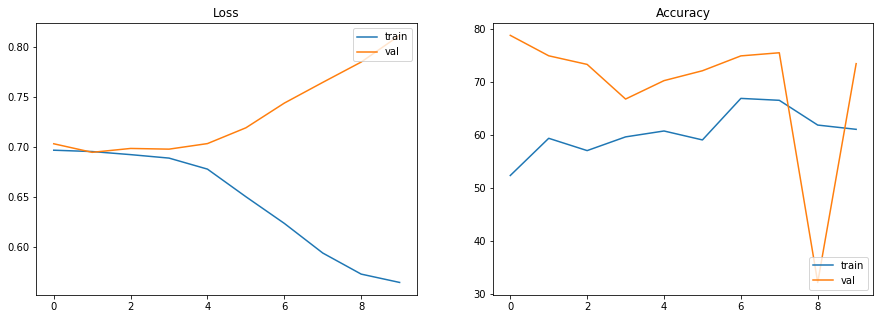

In [0]:
#%% ==================================== Main ====================================            
###### Using embeddings ######
#w2v_path = '/content/drive/My Drive/Colab/wikipedia-pubmed-and-PMC-w2v.bin'
#med_w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

def make_embeddings_matrix(words):
    embedding_dim = args.embedding_dim
    embeddings = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in med_w2v:
            embedding_vector = med_w2v[word]
            embeddings[i, :] = embedding_vector[:embedding_dim]            
        else:
            embedding_i = torch.zeros(1, embedding_dim)
            nn.init.xavier_uniform_(embedding_i)
            embeddings[i, :] = embedding_i
    return embeddings

args.use_med_embeddings = True    


###### Initialization ######
dataset = PapersDataset.load_dataset_and_make_vectorizer(df=split_df, cutoff=args.cutoff)
dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer

# Create embeddings
embeddings = None
if args.use_med_embeddings:
    words = vectorizer.paper_vocab.token_to_idx.keys()
    embeddings = make_embeddings_matrix(words=words)
    print ("<Embeddings(words={0}, dim={1})>".format(np.shape(embeddings)[0], np.shape(embeddings)[1])) 

del(med_w2v)

# Initialize model 
model = PapersModel(embedding_dim=args.embedding_dim, 
                    num_embeddings=len(vectorizer.paper_vocab), 
                    rnn_hidden_dim=args.rnn_hidden_dim,
                    hidden_dim=args.hidden_dim,
                    output_dim=len(vectorizer.label_vocab),
                    num_layers=args.num_layers,
                    bidirectional=args.bidirectional,
                    dropout_p=args.dropout_p, 
                    pretrained_embeddings=embeddings, 
                    padding_idx=vectorizer.paper_vocab.mask_index)
print(model.named_modules)


###### Train ######
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)

start_time = time.time()
trainer.run_train_loop()
elapsed_time = time.time() - start_time


# Test performance
trainer.run_test_loop()
print ("[Test] loss: {0:.3f} | accuracy: {1:.2f}% | sensitivity: {2:.2f}% | specificity: {3:.2f}% | precision: {4:.2f}% | f1: {5:.2f}%".format(
         trainer.train_state['test_loss'], trainer.train_state['test_acc'], 
         trainer.train_state['test_sens'], trainer.train_state['test_spec'], 
         trainer.train_state['test_prec'], trainer.train_state['test_f1']))
print('Time elapsed: {0:.1f} minutes\n'.format(elapsed_time/60))


# Plot performance
trainer.plot_performance()